In [71]:
import regex as re
import numpy as np
import torch
import torch.nn as nn
import pickle
from gensim.models import Word2Vec
from torch.utils.data import DataLoader

from modules.TextCleaner import TextClean
from modules.ReviewVectoriser import Vectoriser
from modules.Networks import Autoencoder
from modules.Analyse import Analyse

In [76]:
# general variables
with open("data/stop_words", "rb") as fp:
    stop_words = pickle.load(fp)
method_choices = ['word2vec', 'TFIDF', 'glove']
vectorise_method = method_choices[1]
verbose = True
ratings_to_analyse = [1, 2, 3, 4, 5]
phrase_lens = [1, 2]

vocab_extractor_vars = {
                'min_df' : 2,
                'max_df' : 300,
                'keep_top_n' : 1000
            }

# variables for word2vec
word2vec_vars = {
                'min_count' : 2,
                'window_size' : 2,
                'emb_size' : 300
                }

# variables for autoencoder
criterion_AE = nn.MSELoss()
AE_vars = {
            'batch_size' : 40,
            'max_epochs' : 160,
            'lr' : 0.0001,
            'weight_decay' : 0.00001
            }

In [77]:
# open reviews and ratings and store in lists
with open("data/reviews", "rb") as fp:
    reviews_dict = pickle.load(fp)

star_ratings = []
reviews = []
for rating in reviews_dict:
    star_ratings += reviews_dict[rating][1]
    reviews += reviews_dict[rating][0]
star_ratings = np.reshape(np.array(star_ratings), (len(star_ratings), 1))

print(f'Number of reviews scraped: {len(reviews)}')

Number of reviews scraped: 13450


In [78]:
# clean reviews
cleaner = TextClean(stop_words=stop_words, verbose=verbose, phrase_lens=phrase_lens)
cleaned_reviews, star_rating = cleaner.clean_up(reviews, star_ratings, verbose)

# vectorise reviews
vectoriser = Vectoriser(
                        stop_words=stop_words, 
                        verbose=verbose, 
                        phrase_lens=phrase_lens,
                        word2vec_vars=word2vec_vars,
                        vocab_extractor_vars=vocab_extractor_vars
                        )
vectorised_reviews, star_ratings, review_info = vectoriser.vectorise( 
                                                        cleaned_reviews,
                                                        reviews,
                                                        star_ratings,
                                                        vectorise_method
                                                        )


... cleaning ...

Number of reviews left after cleaning: 13450
Percentage of words removed using stop word list: 40.2%
Average num of ngrams in text after cleaning: 65.8

... vectorising ...

Size of vocab: 1000
Number of vectorised reviews after vectorisation: 11999


In [79]:
# train autoencoder
print('... training autoencoder ...')
print('')
torch.manual_seed(200206323)
AE = Autoencoder(vector_len=vectorised_reviews.shape[1])
scaled_text, scaler = AE.scaler(vectorised_reviews)
optimizer = torch.optim.Adam(AE.parameters(), lr=AE_vars['lr'], weight_decay=AE_vars['weight_decay'])
trainloader = torch.utils.data.DataLoader(scaled_text, batch_size=AE_vars['batch_size'], shuffle=True)
running_loss = 0
for epoch in range(AE_vars['max_epochs']):
    for batch in trainloader:
        optimizer.zero_grad()
        estimate = AE(batch.clone().detach().requires_grad_(True).float())
        loss = criterion_AE(estimate, batch.clone().detach().requires_grad_(True).float())
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
    if epoch % 20 == 0 and epoch > 0:
        ave_loss = round(running_loss / (20 * (vectorised_reviews.shape[0] / AE_vars['batch_size'])), 4)
        print(f'Average loss per text at epoch number {epoch} : {ave_loss}')
        running_loss = 0

... training autoencoder ...

Average loss per text at epoch number 20 : 1.0372
Average loss per text at epoch number 40 : 0.9737
Average loss per text at epoch number 60 : 0.9643
Average loss per text at epoch number 80 : 0.9561
Average loss per text at epoch number 100 : 0.9489
Average loss per text at epoch number 120 : 0.9426
Average loss per text at epoch number 140 : 0.9369


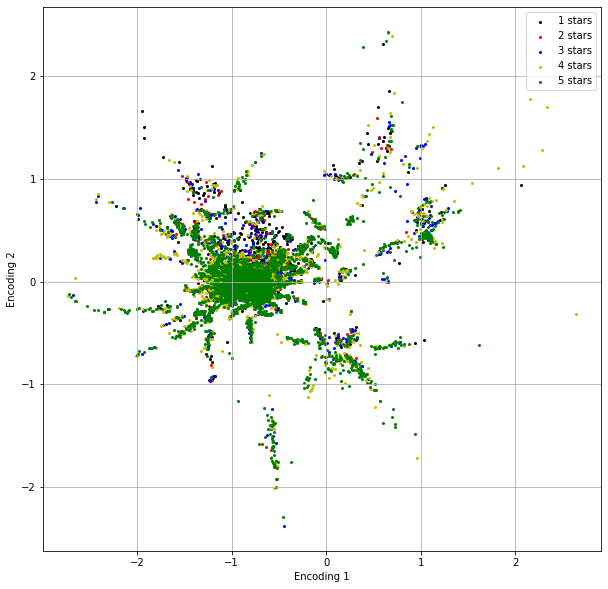

In [83]:
# create encodings and view
encodings = AE.create_encodings(scaled_text)
AE.plot_encodings(encodings, star_ratings)
with open("data/encodings", "wb") as fp:
    pickle.dump(encodings, fp)

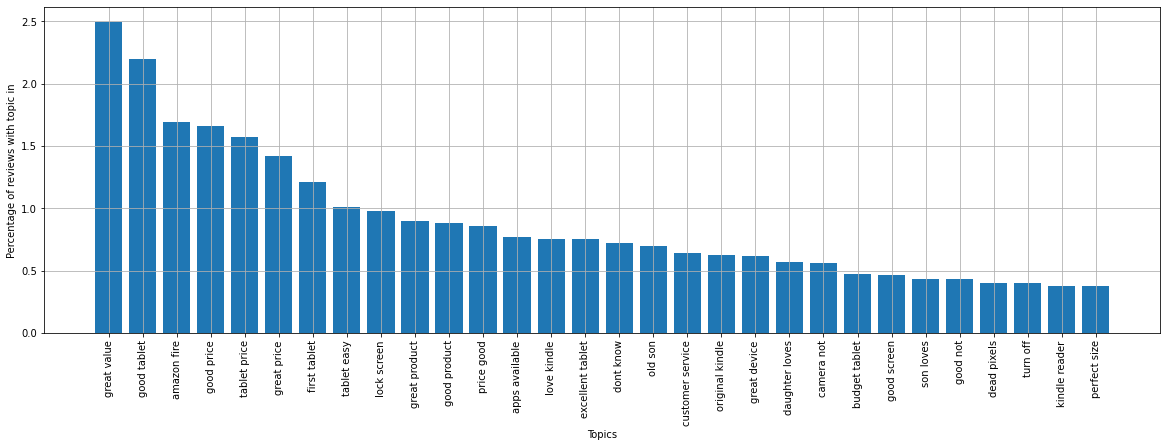

In [88]:
# choose cluster on 2D graph to analyse
analysis = Analyse(
                    encodings=encodings,  
                    scaler=scaler,
                    classifier=star_ratings,
                    vectorised_texts=vectorised_reviews,
                    df_count=review_info['df_counts'],
                    word_to_id = review_info['word_to_ids'],
                    vocab = review_info['vocab'],
                    phrase_lens=phrase_lens
                    )
num_topics = 30

### change encoding values to look at topics in different cluster ###
encoding = [0.2, -0.5]
phrase_len_choice = [2]
topic_list = analysis.topic_extractor(encoding, num_topics, phrase_len_choice)
analysis.topic_popularity_display(topic_list)

Star rating distribution for each topic (rated 1 star to 5 star)



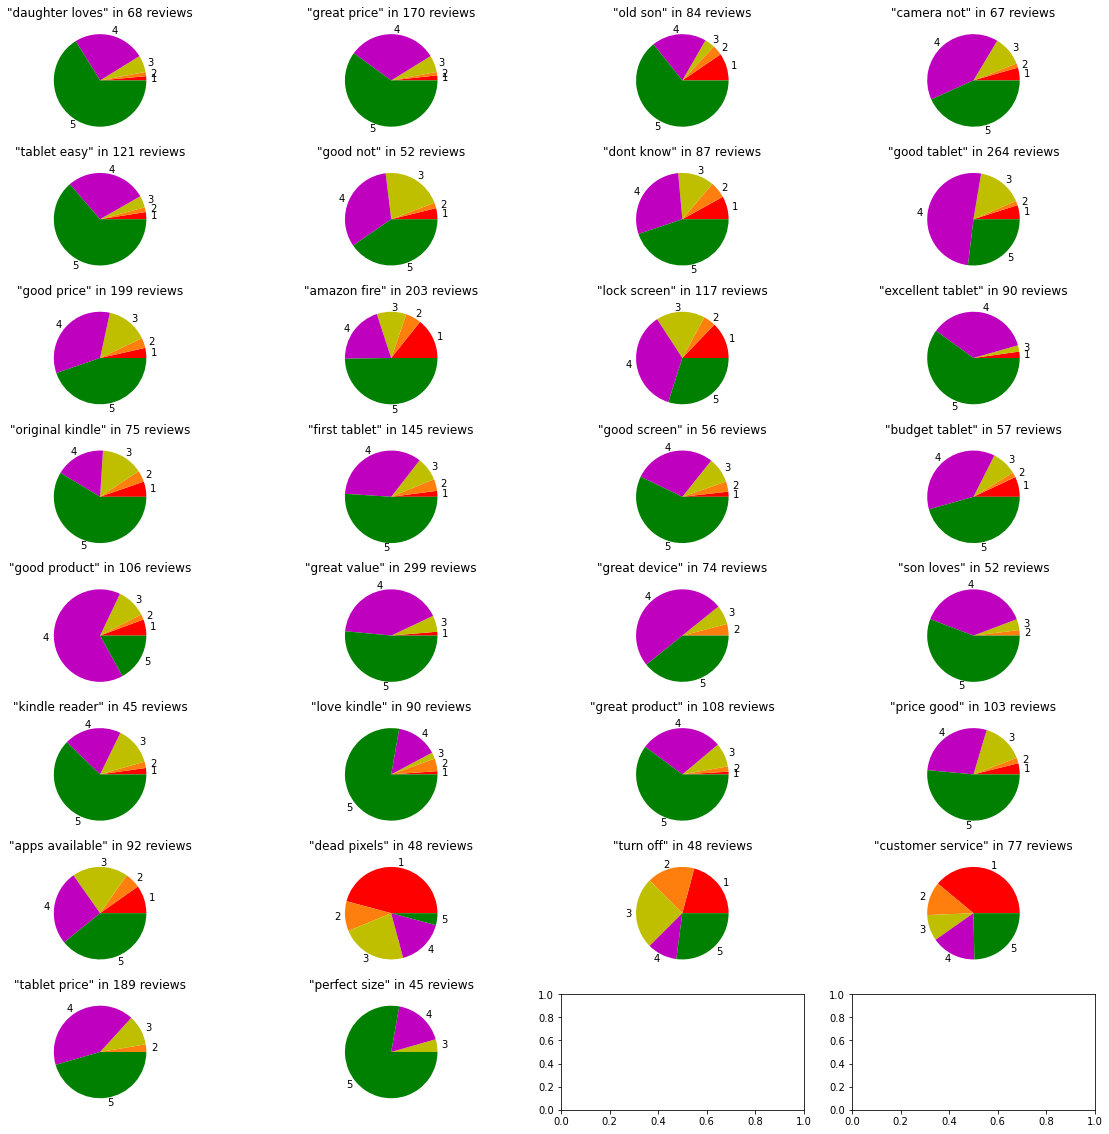

In [89]:
analysis.topic_rating_distribution(topic_list)